In [1]:
import zipfile

from PIL import Image
from PIL import ImageDraw
import pytesseract
import cv2 as cv
import numpy as np
from kraken import pageseg
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract'
TESSDATA_PREFIX = 'C:/Program Files/Tesseract-OCR'
# loading the face detection classifier
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
zipname = input('Enter zip Name: ')
zf = zipfile.ZipFile(zipname)
nl= []
d = {}

for info in zf.infolist():
    f = zf.open(info)
    img = Image.open(f)
    #display(img)
    d['name'] = info.filename
    d['image'] = img
    d['boundingbox'] = None
    d['text']= None
    d['contacsheet']= None
    nl.append(d.copy())
    d={}

Enter zip Name: small_img.zip


In [2]:
def show_boxes(img):
    '''Modifies the passed image to show a series of bounding boxes on an image as run by kraken
    :param img: A PIL.Image object
    :return img: The modified PIL.Image object
    '''
    from PIL import ImageDraw
    drawing_object=ImageDraw.Draw(img)
    bounding_boxes=pageseg.segment(img.convert('1'), black_colseps=True)['boxes']
    for box in bounding_boxes:
        drawing_object.rectangle(box, fill = None, outline ='red')
    return img

In [3]:
char_width=25
def calculate_line_height(img):
    '''Calculates the average height of a line from a given image
    :param img: A PIL.Image object
    :return: The average line height in pixels
    '''
    bounding_boxes=pageseg.segment(img.convert('1'))['boxes']
    height_accumulator=0
    for box in bounding_boxes:
        height_accumulator=height_accumulator+box[3]-box[1]
    return int(height_accumulator/len(bounding_boxes))


In [4]:
for i in range(len(nl)):
    line_height=calculate_line_height(nl[i]['image'])
    nl[i]['line_height'] = line_height

In [5]:
gap_box=(0,0,char_width,nl[0]['line_height']*6)


In [6]:
def gap_check(img, location):
    '''Checks the img in a given (x,y) location to see if it fits the description
    of a gap_box
    :param img: A PIL.Image file
    :param location: A tuple (x,y) which is a pixel location in that image
    :return: True if that fits the definition of a gap_box, otherwise False
    '''
    for x in range(location[0], location[0]+gap_box[2]):
        for y in range(location[1], location[1]+gap_box[3]):
            if x < img.width and y < img.height:
                if img.getpixel((x,y)) != 255:
                    return False
    return True

In [7]:
def draw_sep(img,location):
    '''Draws a line in img in the middle of the gap discovered at location. Note that
    this doesn't draw the line in location, but draws it at the middle of a gap_box
    starting at location.
    :param img: A PIL.Image file
    :param location: A tuple(x,y) which is a pixel location in the image
    '''
    from PIL import ImageDraw
    drawing_object=ImageDraw.Draw(img)
    x1=location[0]+int(gap_box[2]/2)
    x2=x1
    y1=location[1]
    y2=y1+gap_box[3]
    drawing_object.rectangle((x1,y1,x2,y2), fill = 'black', outline ='black')

In [8]:
def process_image(img):
    '''Takes in an image of text and adds black vertical bars to break up columns
    :param img: A PIL.Image file
    :return: A modified PIL.Image file
    '''
    for x in range(img.width):
        for y in range(img.height):
            # check if there is a gap at this point
            if (gap_check(img, (x,y))):
                # then update image to one which has a separator drawn on it
                draw_sep(img, (x,y))
    return img

In [9]:
for i in range(len(nl)):
    im = process_image(nl[i]['image'])
    strg= pytesseract.image_to_string(im)
    strg = strg.lower()
    nl[i]['text'] = strg

In [25]:
for i in range(len(nl)):
    nl[i]['boundingbox']= []
    nl[i]['contactsheet'] = None

In [26]:
for i in range(len(nl)):
    imgg = np.asarray(nl[i]['image'])
    gray = cv.cvtColor(imgg, cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.4,4)
    for x,y,w,h in faces:
        face = nl[i]['image'].crop((x,y,x+w,y+h))
        nl[i]['boundingbox'].append(face)
        #display(face)
    #ImageDraw.Draw(nl[i]['image']).rectangle((rec[0],rec[1],rec[0]+rec[2],rec[1]+rec[3]), outline="red")
    #display(nl[0]['image'])

In [27]:
for i in  range(len(nl)):   
    contact_sheet= contact_sheet = Image.new('RGB', (550,100*int(np.ceil(len(nl[i]['boundingbox'])/5))))
    x=0
    y=0
    for face in nl[i]['boundingbox']:
        face.thumbnail((110,110))
        contact_sheet.paste(face, (x, y))       
        if x+110 == contact_sheet.width:
            x=0
            y=y+110
        else:
            x=x+110

    nl[i]['contactsheet'] = contact_sheet

What do you search for: Christopher


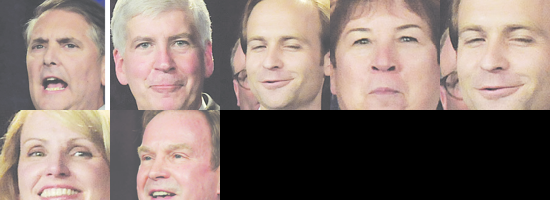

Result found in file a-0.png
But there were no faces in that file!
But there were no faces in that file!


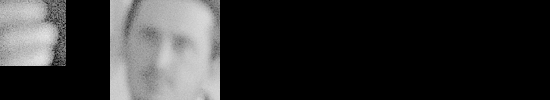

Result found in file a-3.png


In [28]:
user = input('What do you search for: ')
user = user.lower()
for i in range(len(nl)):
    if user in nl[i]['text']:
        display(nl[i]['contactsheet'])
        print('Result found in file {}'.format(nl[i]['name']))
    else:
        print('But there were no faces in that file!')

